## numpyro with OIData and BinaryModelCartesian

In [28]:
from jax import config
config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.random as jr

import numpy as onp 
import matplotlib.pyplot as plt

import drpangloss
# from drpangloss.oifits_implaneia import load_oifits, cp_indices
from drpangloss.models import BinaryModelAngular, BinaryModelCartesian, OIData
from drpangloss.grid_fit import azimuthalAverage

import pyoifits as oifits

import numpyro as npy
import numpyro.distributions as dist

import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

Load the JWST/AMI F480M data, and simulate a similar dataset with a fake binary.

In [2]:
fname = "NuHor_F480M.oifits"
ddir = "../data/"

data = oifits.open(ddir+fname)

data.verify('silentfix')

oidata = OIData(data)

true_values = [150., 150., 5e-4] # ra, dec, planet flux
binary = BinaryModelCartesian(true_values[0], true_values[1], true_values[2])

cvis_sim = binary.model(oidata.u, oidata.v, oidata.wavel) 

# fill out a new oidata model with simulated values
sim_data = {'u': oidata.u,
            'v': oidata.v,
            'wavel': oidata.wavel,
            'vis': oidata.to_vis(cvis_sim) + onp.random.randn(*oidata.vis.shape)*oidata.d_vis,
            'd_vis': oidata.d_vis,
            'phi': oidata.to_phases(cvis_sim) + onp.random.randn(*oidata.phi.shape)*oidata.d_phi,
            'd_phi': oidata.d_phi,
            'i_cps1': oidata.i_cps1,
            'i_cps2': oidata.i_cps2,
            'i_cps3': oidata.i_cps3,
            'v2_flag': oidata.v2_flag,
            'cp_flag': oidata.cp_flag}

oidata_sim = OIData(sim_data)

Write down a numpyro sampling function: perhaps this is a template for something that should be auto-generated by the appropriate model class.

In [13]:
def sampling_fn(data_obj, model_class):

    # Define priors
    dra, ddec, log_flux = [npy.sample("Δ RA",    dist.Uniform(100, 200)), 
              npy.sample("Δ Dec",   dist.Uniform(100, 200)),
              npy.sample("log Flux",    dist.Uniform(-5,-3))
            ] 
    # TODO: how do we set appropriate priors in Cartesian coordinates? 
    # TODO: it would be good for this to be defined by the model_class itself

    flux = 10**log_flux # sample in log flux 

    # predict the data 
    pred_data = npy.deterministic("pred", data_obj.model(model_class(dra,ddec,flux)))

    data, errors = data_obj.flatten_data()
    # Sample from the posterior distribution
    model_sampler = dist.Normal(pred_data,errors 
                                )
    return npy.sample("Sampler", model_sampler, obs=data)


Run HMC:

In [75]:
# Using the model above, we can now sample from the posterior distribution
# using the No U-Turn Sampler (NUTS).
sampler = npy.infer.MCMC(
    npy.infer.NUTS(sampling_fn),
    num_warmup=5000,
    num_samples=5000,
)
sampler.run(jr.PRNGKey(0), oidata_sim, BinaryModelCartesian)

posterior_pred = sampler.get_samples()['pred']


sample: 100%|██████████| 10000/10000 [00:02<00:00, 4286.50it/s, 7 steps of size 7.78e-01. acc. prob=0.91]


Visualize the output using ChainConsumer:

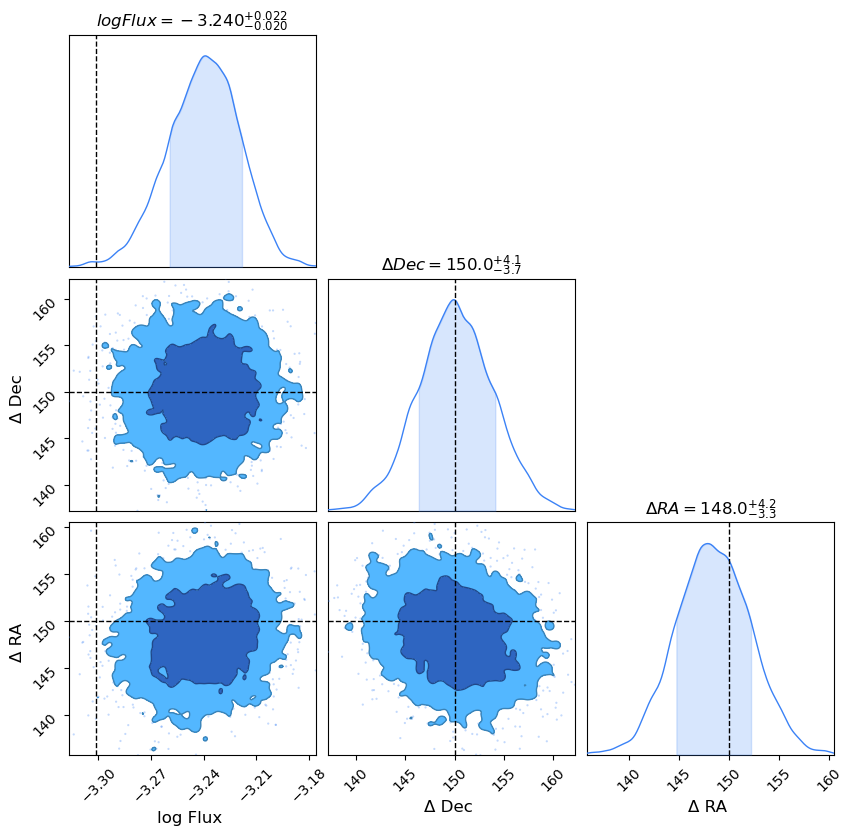

In [76]:
results = sampler.get_samples()
results.pop('pred') # remove the prediction from the results
cc_df = pd.DataFrame.from_dict(results)

c = ChainConsumer()  
c.add_chain(Chain(samples=cc_df,name="MCMC Results",
                                   plot_point=True,
                                    plot_cloud=True,
                                    marker_style="*",
                                    marker_size=100,
                                ))
truths = {key:val for key, val in zip(results.keys(), [np.log10(5e-4), 150., 150.])} # TODO: the ordering should be fixed
c.add_truth(Truth(location=truths))
c.plotter.plot()
  
plt.show()  


How did we go in the posterior predictive distributions? It's hard to visualize interferometric data but we can try a correlation plot:

Text(0.5, 1.0, 'Closure Phases')

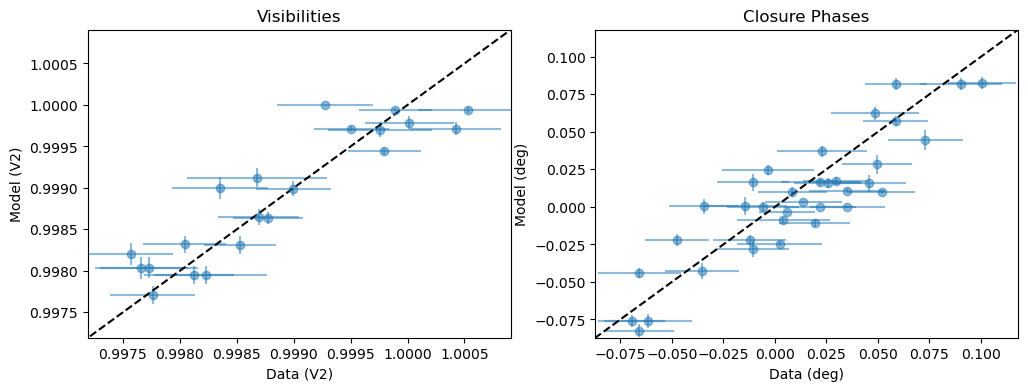

In [77]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

posterior_mean = np.mean(posterior_pred, axis=0)
posterior_std = np.std(posterior_pred, axis=0)

# plot data 
ax1.errorbar(oidata_sim.vis, posterior_mean[:len(oidata_sim.vis)], 
             xerr=oidata_sim.d_vis, yerr = posterior_std[:len(oidata_sim.vis)],
             fmt='o', alpha=0.5,color='C0')

ax2.errorbar(oidata_sim.phi, posterior_mean[len(oidata_sim.vis):], 
             xerr=oidata_sim.d_phi, yerr = posterior_std[len(oidata_sim.vis):],
             fmt='o', alpha=0.5,color='C0')

vis_121 = np.linspace(oidata_sim.vis.min()-np.median(oidata_sim.d_vis)*2, oidata_sim.vis.max()+np.median(oidata_sim.d_vis)*2, 100)
phi_121 = np.linspace(oidata_sim.phi.min()-np.median(oidata_sim.d_phi)*2, oidata_sim.phi.max()+np.median(oidata_sim.d_phi)*2, 100)

# plot 1:1 lines
ax1.plot(vis_121, vis_121, 'k--')
ax1.set_xlim(oidata_sim.vis.min()-np.median(oidata_sim.d_vis), oidata_sim.vis.max()+np.median(oidata_sim.d_vis))
ax1.set_ylim(oidata_sim.vis.min()-np.median(oidata_sim.d_vis), oidata_sim.vis.max()+np.median(oidata_sim.d_vis))

ax2.plot(phi_121, phi_121, 'k--')
ax2.set_xlim(oidata_sim.phi.min()-np.median(oidata_sim.d_phi), oidata_sim.phi.max()+np.median(oidata_sim.d_phi))
ax2.set_ylim(oidata_sim.phi.min()-np.median(oidata_sim.d_phi), oidata_sim.phi.max()+np.median(oidata_sim.d_phi))

# plot labels 
ax1.set_xlabel('Data (V2)')
ax1.set_ylabel('Model (V2)')
ax1.set_title('Visibilities')

ax2.set_xlabel('Data (deg)')
ax2.set_ylabel('Model (deg)')
ax2.set_title('Closure Phases')

It's interesting that there is much less scatter in the posterior predictive visibilities and phases than in the data - is this what we expect?